# Activity Recognition Using Wearable Physiological Measurements: Selection of Features from a Comprehensive Literature Study

This study had the goal of being able to detect different forms of activity by monitoring different metrics of the human body, such as heart activity, lung activity and physical movement of the arm and hand.

The 4 types of activity present in the study are:
    
    1. Neutral;
    2. Emotional;
    3. Mental;
    4. Physical.

The way to induce such activities are as follows:

    - Neutral: by having the subjects watch documentaries;
    - Emotional: by having the subjects watch movies;
    - Mental: by having the subjects play games of mental arithmetics and tetris;
    - Physical: by having the subjects go up and down flights of stairs.

In [86]:
import pandas as pd
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from genetic_selection import GeneticSelectionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns;
import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data provided from the "Activity recognition using wearable physiological measurements" dataset consists in 4480 instances of 533 features each.

The first column correspond to the index of the subject. The next 174 attributes are statistics extracted from the ECG signal. The next 151 attributes are features extracted from the TEB signal. The next 104 attributes come from the EDA measured in the arm, and the next 104 ones from the EDA in the hand. The last attribute is the pattern class, that is, the corresponding activity: 1-neutral, 2-emotional, 3-mental and 4-physical.

In [45]:
with open("data/labels.txt","r",encoding="utf-8") as f:
    labels = f.read().split("\n")
    #print(labels)
#labelset=set(labels)
for n in range(len(labels)):
    if 263<=n<=276:
        labels[n] = labels[n] + "_2"
    if 326<=n<=429:
        labels[n]="Arm_" + labels[n]
    if 430<=n<=533:
        labels[n]="Hand_" + labels[n] 
    if n == len(labels)-1:
        labels[n]="Activity"
n=0
"""
for i in labels:
    print(n,i, labels.count(i))
    n+=1
"""

'\nfor i in labels:\n    print(n,i, labels.count(i))\n    n+=1\n'

In [46]:
df=pd.read_csv("data/data.txt",sep=",",names=labels)

In [47]:
df

,Subject index (1_40),ECG_original_mean,ECG_original_std,ECG_original_trimmean25,ECG_original_median,ECG_original_skewness,ECG_original_kurtosis,ECG_original_max,ECG_original_min,ECG_original_prctile25,...,Hand_EDA_Functionals_power_Filt2kurtosis,Hand_EDA_Functionals_power_Filt2max,Hand_EDA_Functionals_power_Filt2min,Hand_EDA_Functionals_power_Filt2prctile25,Hand_EDA_Functionals_power_Filt2prctile75,Hand_EDA_Functionals_power_Filt2geomean(abs),Hand_EDA_Functionals_power_Filt2harmmean,Hand_EDA_Functionals_power_Filt2mad,Hand_EDA_Functionals_power_Filt2baseline,Activity
0,1,-0.004125,0.254095,0.001426,-0.01037,-0.538509,5.95534,1.04063,-1.37437,-0.10937,...,1015.36,7.170320e+08,0.027384,2.53425,17.3882,8.05589,1.80247,1413310.0,3028080.0,1
1,1,0.031029,0.193761,0.012918,-0.00237,0.781415,5.18794,0.98963,-0.71937,-0.08737,...,1015.78,7.058540e+08,0.016947,2.51513,16.5914,7.81769,1.52349,1390180.0,3016420.0,1
2,1,0.015678,0.182336,-0.003028,-0.02337,0.881194,5.66530,0.87563,-0.71937,-0.08037,...,1016.16,6.270180e+08,0.008129,2.25959,15.2312,7.11684,1.25860,1234110.0,3004430.0,1
3,1,0.014525,0.176636,-0.006161,-0.02737,1.024900,6.10968,0.91063,-0.71937,-0.08037,...,1015.61,5.597480e+08,0.007377,2.13924,14.4663,6.70236,1.26643,1102720.0,2992170.0,1
4,1,0.010349,0.179248,-0.008526,-0.02737,0.935697,5.83902,0.91063,-0.75637,-0.08337,...,1015.67,4.844730e+08,0.011448,1.93595,12.5493,6.08647,1.22387,954322.0,2979610.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,40,-0.015981,0.254373,-0.013341,-0.00101,-0.165105,5.15843,1.03999,-1.19301,-0.15801,...,1014.61,3.237410e+09,0.132094,9.48535,73.9901,31.82590,5.16972,6390410.0,398810.0,4
4476,40,-0.008857,0.238946,-0.010767,-0.00901,-0.034522,5.43013,1.01499,-1.10201,-0.14501,...,1016.07,3.156070e+09,0.133406,8.73701,68.4041,29.83820,5.06743,6214830.0,412407.0,4
4477,40,0.024672,0.213325,0.014418,0.01099,0.613841,4.55481,1.01499,-0.57301,-0.10401,...,1016.06,3.052520e+09,0.138525,8.90410,68.5051,30.45150,5.88492,6011070.0,425422.0,4
4478,40,0.025063,0.212210,0.015656,0.01299,0.593249,4.58374,0.95799,-0.64101,-0.10001,...,1015.80,3.322710e+09,0.076570,8.97766,72.4431,30.38700,4.43563,6544010.0,439695.0,4


In [48]:
df.groupby('Activity').mean()

,Subject index (1_40),ECG_original_mean,ECG_original_std,ECG_original_trimmean25,ECG_original_median,ECG_original_skewness,ECG_original_kurtosis,ECG_original_max,ECG_original_min,ECG_original_prctile25,...,Hand_EDA_Functionals_power_Filt2skewness,Hand_EDA_Functionals_power_Filt2kurtosis,Hand_EDA_Functionals_power_Filt2max,Hand_EDA_Functionals_power_Filt2min,Hand_EDA_Functionals_power_Filt2prctile25,Hand_EDA_Functionals_power_Filt2prctile75,Hand_EDA_Functionals_power_Filt2geomean(abs),Hand_EDA_Functionals_power_Filt2harmmean,Hand_EDA_Functionals_power_Filt2mad,Hand_EDA_Functionals_power_Filt2baseline
Activity,,,,,,,,,,,,,,,,,,,,,
1,20.5,-0.017248,0.224012,-0.035954,-0.056528,0.937650,8.602679,0.958904,-0.723009,-0.147302,...,31.076512,999.006146,9.787362e+09,0.086875,26.094028,209.055769,79.662689,5.520061,1.927879e+07,1.358014e+07
2,20.5,-0.015742,0.293427,-0.030485,-0.054670,0.935858,8.273527,1.049734,-0.849642,-0.198350,...,30.909530,991.348837,1.181007e+10,0.096258,31.243043,251.225875,95.839197,6.893809,2.326209e+07,1.275656e+07
3,20.5,-0.017345,0.286182,-0.033134,-0.057011,0.840043,7.112982,1.019942,-0.845316,-0.209066,...,30.818430,987.180680,1.783115e+10,0.106472,46.549498,376.558618,142.193595,8.290682,3.512487e+07,1.302790e+07
4,20.5,0.326771,1.151261,0.357649,0.443789,-0.149969,3.957743,2.987728,-2.554684,-0.486353,...,31.161746,1002.965500,3.190325e+10,0.297815,83.263698,675.167256,259.468831,16.685674,6.286903e+07,1.502544e+07


In [49]:
#futures =['Subject index (1_40)',
        #'ECG_hrv_geomean(abs)','ECG_RR_window_mean','ECG_Logstd','ECG_A1_DFA','ECG_HR_min_div_mean',
        #'ECG_hrv_mean', 'ECG_amplitude_RR_mean','ECG_original_skewness','ECG_amplitude_RR_mad','ECG_amplitude_RR_std',
        #'ECG_RR_window_trimmean25','ECG_RR_window_median','ECG_RR_window_geomean(abs)','IT_RF_mean','IT_BRV_mean',
        #'IT_BRV_min','IT_PSD_mean','IT_VLF_mean','IT_MF_mean','IT_LF_mean',
        #'IT_HF_LF','IT_BRV_mean','IT_LF_MF_HF','IT_Original_mean','IT_MF_HF',
        #'IT_RF_mean','IT_LF_prctile75','IT_Original_prctile75','Hand_EDA_Original_mean','Hand_EDA_processed_mean',
        #'Hand_EDA_Functionals_power_Fil12mean','Hand_EDA_amp_scr','Hand_EDA_Functionals_power_Filt2mean','Arm_EDA_processed_skewness','Hand_EDA_n_ocu',
        #'Hand_EDA_cross_neg','Hand_EDA_cross_pos','Hand_EDA_processed_max','Hand_EDA_processed_min','Hand_EDA_processed_median',
        #'Activity']
#df2=df[futures]


In [50]:
#df2

In [51]:
#from sklearn.model_selection import train_test_split
#a=np.linspace(1120,4479, num=3360)
#X=X.drop(a)
#y=y.drop(a)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

## Data and Variable Definition

In [52]:
X = df.drop("Activity", axis=1)
y = df["Activity"]
n_subject=40
N_max = [5, 10, 20, 40, 80]
classificator_label=["VSM_linear","VSM_rbf","mlp","knn","rf"]

In [53]:
print("X.shape = " + str(X.shape))
print("y.shape = " + str(y.shape))

X.shape = (4480, 534)
y.shape = (4480,)


## Function Definition

In [54]:
def print_accuracy_table(accuracies,labels):
    print("Accuracy of the classifiers/n")
    data = {"VSM_linear":[accuracies[0]],"VSM_rbf":[accuracies[1]],"mlp":[accuracies[2]],"knn":[accuracies[3]],"rf":[accuracies[4]]}
    df1=pd.DataFrame(data, columns=labels)
    df1.style
    print(df1)

In [91]:
def get_confusion_matrix(y_pred):
    mat = confusion_matrix(y, y_pred)
    print("CONFUSION MATRIX")
    hm=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Neutral','Emotional','Mental','Physical'],
                yticklabels=['Neutral','Emotional','Mental','Physical'])
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.show()

In [56]:
def get_classification_report(y_pred):
    print("CLASSIFICATION REPORT")
    print(classification_report(y, y_pred,
                            target_names=['Neutral','Emotional','Mental','Physical']))

In [57]:
def apply_classifier_to_dataset(clf, clf_name):
    print("CLASSIFICATION FOR:"+ clf_name)
    for f_set in Feature_Set:
        for k in N_max:
            print("Classification for set "+ f_set +"k="+str(k))
            Xtemp=X[report[f_set][k]["Chosen Feats"]]
            clf.fit(Xtemp,y)
            y_pred = cross_val_predict(clf, Xtemp, y, cv=n_subject)
            get_confusion_matrix(y_pred)
            get_classification_report(y_pred)
            
                

## Feature Selection

Feature selection is the process of selecting a subset of the most relevant features. There are mainly two reasons to use feature selection: to reduce the generalization problems by reducing overfitting and to simplify the model.
To select the best features of dataset we use a geneti algorithm (GA).In a genetic algorithm, a population of candidate solutions (called individuals,) to an optimization problem is evolved toward better solutions. Each candidate solution has a set of properties (called chromosomes) which can be mutated and altered.
In our case in first we separete each measurement data in their category and than we apply the GA for each category on four different feature sets of [5,10,20,40] features each. The result of evry iteration of the algorithm are the features chosen by the algorithm.

In [34]:
pd.options.display.max_rows = 4000

Separate each measurement data in their category

In [35]:
df_ECG = df[[col for col in df if col.startswith('ECG')]]#X.iloc[:, 1:175]
df_TEB = df[[col for col in df if col.startswith('IT')]]#X.iloc[:, 176:326]
df_EDA_arm = df[[col for col in df if col.startswith('Arm')]]#X.iloc[:, 327:430]
df_EDA_hand = df[[col for col in df if col.startswith('Hand')]]#X.iloc[:, 431:534]
Feature_Set = {"ECG":df_ECG,"TEB":df_TEB,"ARM":df_EDA_arm,"HAND":df_EDA_hand}


In [60]:
# For this work, the number of features selected was discretized by group size in 5, 10, 20, 40, 60, 80 and the full set
#N_max = [5, 10, 20, 40, 60, 80]
#N_max.append(X_ECG.shape[1])
 #######removed 40 just for faster testing
report = {}
cv = cv = KFold(n_splits=40, random_state=1, shuffle=True)

# Each combination is ranked using the mean squared error of a LSLC measured using the design set.
for f_set in Feature_Set:
    estimator = LogisticRegression(solver = "liblinear", C = 6, tol = 1, fit_intercept = True)
    report[f_set]={}
    #report = pd.DataFrame()
    nofeats = [] 
    chosen_feats = [] 
    cvscore = [] 

    # for each of the N_max we'll select the best features usig a Genetic Algorithm
    for k in N_max:

        print("\nFinding features whith a N_max = " + str(k) + " for set of features " + f_set +"...")

        selector = GeneticSelectionCV(estimator,
                                    cv = cv,
                                    verbose = 0,
                                    scoring = "accuracy",
                                    max_features = k,
                                    n_population = 100,
                                    crossover_proba = 0.5,
                                    mutation_proba = 0.2,
                                    n_generations = 10,
                                    crossover_independent_proba=0.5,
                                    mutation_independent_proba=0.01,
                                    tournament_size = 3,
                                    n_gen_no_change=10,
                                    caching=True,
                                    n_jobs=-1)

        
        selector = selector.fit(Feature_Set[f_set], y)

        genfeats = Feature_Set[f_set].columns[selector.support_]
        genfeats = list(genfeats)
        print("Chosen Feats:  ", genfeats)
        

        cv_score = selector.generation_scores_[-1]
        nofeats=len(genfeats)
        chosen_feats = genfeats
        cvscore=cv_score
    #########saving to dict to access later    
        report[f_set][k]={}
        report[f_set][k]["No of Feats"] = nofeats
        report[f_set][k]["Chosen Feats"] = chosen_feats
        report[f_set][k]["Scores"] = cvscore

    print(report[f_set][k])


Finding features whith a N_max = 5 for set of features ECG...
Chosen Feats:   ['ECG_amplitude_RR_kurtosis', 'ECG_EI', 'ECG_NN50', 'ECG_hrv_trimmean25', 'ECG_hrv_baseline']

Finding features whith a N_max = 10 for set of features ECG...
Chosen Feats:   ['ECG_original_min', 'ECG_original_baseline', 'ECG_RR_window_min', 'ECG_RR_window_harmmean', 'ECG_RR_window_mad', 'ECG_HR_min_div_trimmean25', 'ECG_DBD', 'ECG_EI', 'ECG_hrv_trimmean25', 'ECG_A1_DFA']

Finding features whith a N_max = 20 for set of features ECG...
Chosen Feats:   ['ECG_NN50', 'ECG_hrv_trimmean25', 'ECG_hrv_kurtosis', 'ECG_p_LF_skewness', 'ECG_p_LF_kurtosis', 'ECG_p_total_LF_mad']

Finding features whith a N_max = 40 for set of features ECG...
Chosen Feats:   ['ECG_amplitude_RR_trimmean25', 'ECG_amplitude_RR_geomean(abs)', 'ECG_amplitude_RR_harmmean', 'ECG_HR_min_div_kurtosis', 'ECG_EI', 'ECG_NN50', 'ECG_hrv_mean', 'ECG_hrv_median', 'ECG_hrv_min', 'ECG_hrv_prctile75', 'ECG_PSD_skewness', 'ECG_p_VFL_skewness', 'ECG_p_LF_bas

## Classification

### Least Squares Linear Classifier (LSLC)

In [61]:
chosen_feats

['Hand_EDA_processed_mean',
 'Hand_EDA_Filt1_min',
 'Hand_EDA_Filt2_median',
 'Hand_EDA_Functionals_power_Fil12mean',
 'Hand_EDA_Functionals_power_Fil12min',
 'Hand_EDA_Functionals_power_Fil12prctile75',
 'Hand_EDA_Functionals_power_Fil12baseline',
 'Hand_EDA_Functionals_power_Filt2mean',
 'Hand_EDA_Functionals_power_Filt2trimmean25']

CLASSIFICATION FOR: LSLC
Classification for set ECGk=5
CONFUSION MATRIX


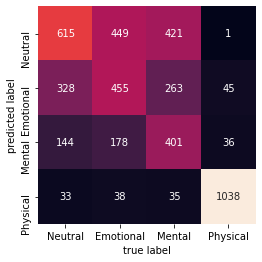

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.41      0.55      0.47      1120
   Emotional       0.42      0.41      0.41      1120
      Mental       0.53      0.36      0.43      1120
    Physical       0.91      0.93      0.92      1120

    accuracy                           0.56      4480
   macro avg       0.57      0.56      0.56      4480
weighted avg       0.57      0.56      0.56      4480

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.11 µs
Classification for set ECGk=10
CONFUSION MATRIX


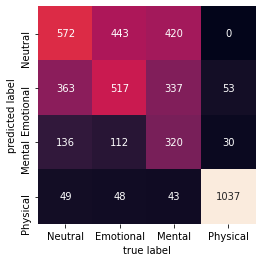

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.40      0.51      0.45      1120
   Emotional       0.41      0.46      0.43      1120
      Mental       0.54      0.29      0.37      1120
    Physical       0.88      0.93      0.90      1120

    accuracy                           0.55      4480
   macro avg       0.56      0.55      0.54      4480
weighted avg       0.56      0.55      0.54      4480

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs
Classification for set ECGk=20
CONFUSION MATRIX


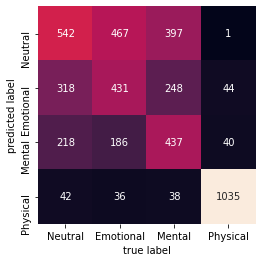

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.39      0.48      0.43      1120
   Emotional       0.41      0.38      0.40      1120
      Mental       0.50      0.39      0.44      1120
    Physical       0.90      0.92      0.91      1120

    accuracy                           0.55      4480
   macro avg       0.55      0.55      0.54      4480
weighted avg       0.55      0.55      0.54      4480

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.34 µs
Classification for set ECGk=40
CONFUSION MATRIX


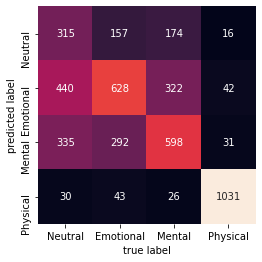

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.48      0.28      0.35      1120
   Emotional       0.44      0.56      0.49      1120
      Mental       0.48      0.53      0.50      1120
    Physical       0.91      0.92      0.92      1120

    accuracy                           0.57      4480
   macro avg       0.58      0.57      0.57      4480
weighted avg       0.58      0.57      0.57      4480

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 9.06 µs
Classification for set ECGk=80
CONFUSION MATRIX


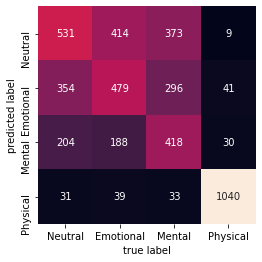

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.40      0.47      0.43      1120
   Emotional       0.41      0.43      0.42      1120
      Mental       0.50      0.37      0.43      1120
    Physical       0.91      0.93      0.92      1120

    accuracy                           0.55      4480
   macro avg       0.55      0.55      0.55      4480
weighted avg       0.55      0.55      0.55      4480

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 12.2 µs
Classification for set TEBk=5
CONFUSION MATRIX


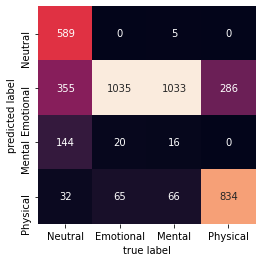

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.99      0.53      0.69      1120
   Emotional       0.38      0.92      0.54      1120
      Mental       0.09      0.01      0.02      1120
    Physical       0.84      0.74      0.79      1120

    accuracy                           0.55      4480
   macro avg       0.57      0.55      0.51      4480
weighted avg       0.57      0.55      0.51      4480

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs
Classification for set TEBk=10
CONFUSION MATRIX


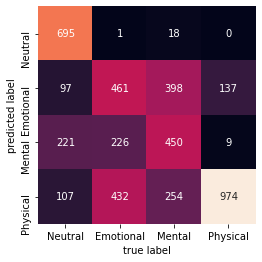

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.97      0.62      0.76      1120
   Emotional       0.42      0.41      0.42      1120
      Mental       0.50      0.40      0.44      1120
    Physical       0.55      0.87      0.67      1120

    accuracy                           0.58      4480
   macro avg       0.61      0.58      0.57      4480
weighted avg       0.61      0.58      0.57      4480

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.58 µs
Classification for set TEBk=20
CONFUSION MATRIX


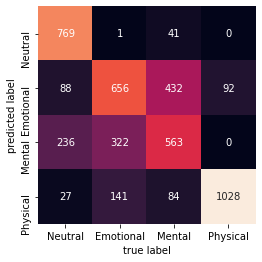

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.95      0.69      0.80      1120
   Emotional       0.52      0.59      0.55      1120
      Mental       0.50      0.50      0.50      1120
    Physical       0.80      0.92      0.86      1120

    accuracy                           0.67      4480
   macro avg       0.69      0.67      0.68      4480
weighted avg       0.69      0.67      0.68      4480

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.06 µs
Classification for set TEBk=40
CONFUSION MATRIX


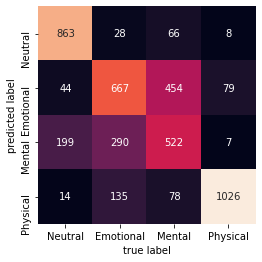

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.89      0.77      0.83      1120
   Emotional       0.54      0.60      0.56      1120
      Mental       0.51      0.47      0.49      1120
    Physical       0.82      0.92      0.86      1120

    accuracy                           0.69      4480
   macro avg       0.69      0.69      0.69      4480
weighted avg       0.69      0.69      0.69      4480

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 12.2 µs
Classification for set TEBk=80
CONFUSION MATRIX


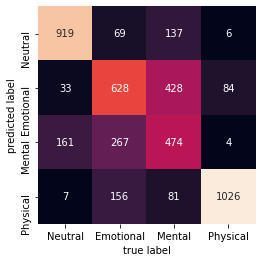

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.81      0.82      0.82      1120
   Emotional       0.54      0.56      0.55      1120
      Mental       0.52      0.42      0.47      1120
    Physical       0.81      0.92      0.86      1120

    accuracy                           0.68      4480
   macro avg       0.67      0.68      0.67      4480
weighted avg       0.67      0.68      0.67      4480

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 6.44 µs
Classification for set ARMk=5
CONFUSION MATRIX


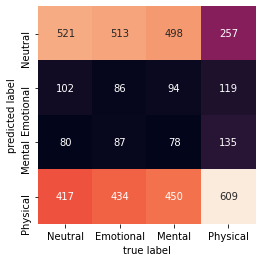

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.29      0.47      0.36      1120
   Emotional       0.21      0.08      0.11      1120
      Mental       0.21      0.07      0.10      1120
    Physical       0.32      0.54      0.40      1120

    accuracy                           0.29      4480
   macro avg       0.26      0.29      0.24      4480
weighted avg       0.26      0.29      0.24      4480

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs
Classification for set ARMk=10
CONFUSION MATRIX


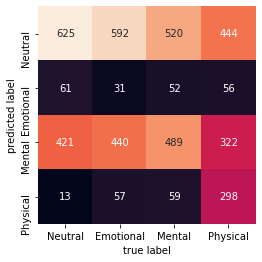

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.29      0.56      0.38      1120
   Emotional       0.15      0.03      0.05      1120
      Mental       0.29      0.44      0.35      1120
    Physical       0.70      0.27      0.39      1120

    accuracy                           0.32      4480
   macro avg       0.36      0.32      0.29      4480
weighted avg       0.36      0.32      0.29      4480

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Classification for set ARMk=20
CONFUSION MATRIX


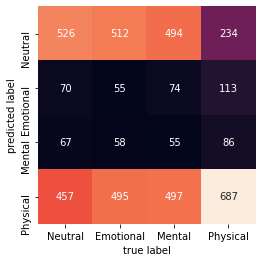

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.30      0.47      0.36      1120
   Emotional       0.18      0.05      0.08      1120
      Mental       0.21      0.05      0.08      1120
    Physical       0.32      0.61      0.42      1120

    accuracy                           0.30      4480
   macro avg       0.25      0.30      0.24      4480
weighted avg       0.25      0.30      0.24      4480

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 10.5 µs
Classification for set ARMk=40
CONFUSION MATRIX


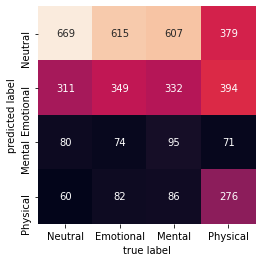

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.29      0.60      0.39      1120
   Emotional       0.25      0.31      0.28      1120
      Mental       0.30      0.08      0.13      1120
    Physical       0.55      0.25      0.34      1120

    accuracy                           0.31      4480
   macro avg       0.35      0.31      0.29      4480
weighted avg       0.35      0.31      0.29      4480

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs
Classification for set ARMk=80
CONFUSION MATRIX


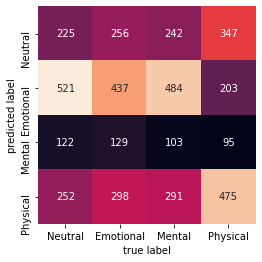

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.21      0.20      0.21      1120
   Emotional       0.27      0.39      0.32      1120
      Mental       0.23      0.09      0.13      1120
    Physical       0.36      0.42      0.39      1120

    accuracy                           0.28      4480
   macro avg       0.27      0.28      0.26      4480
weighted avg       0.27      0.28      0.26      4480

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.63 µs
Classification for set HANDk=5
CONFUSION MATRIX


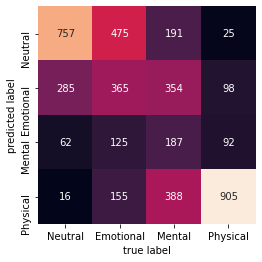

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.52      0.68      0.59      1120
   Emotional       0.33      0.33      0.33      1120
      Mental       0.40      0.17      0.24      1120
    Physical       0.62      0.81      0.70      1120

    accuracy                           0.49      4480
   macro avg       0.47      0.49      0.46      4480
weighted avg       0.47      0.49      0.46      4480

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs
Classification for set HANDk=10
CONFUSION MATRIX


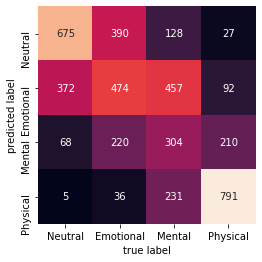

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.55      0.60      0.58      1120
   Emotional       0.34      0.42      0.38      1120
      Mental       0.38      0.27      0.32      1120
    Physical       0.74      0.71      0.72      1120

    accuracy                           0.50      4480
   macro avg       0.50      0.50      0.50      4480
weighted avg       0.50      0.50      0.50      4480

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.01 µs
Classification for set HANDk=20
CONFUSION MATRIX


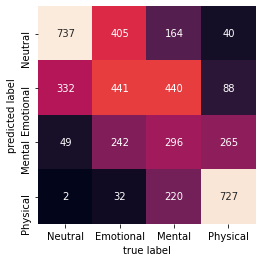

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.55      0.66      0.60      1120
   Emotional       0.34      0.39      0.36      1120
      Mental       0.35      0.26      0.30      1120
    Physical       0.74      0.65      0.69      1120

    accuracy                           0.49      4480
   macro avg       0.49      0.49      0.49      4480
weighted avg       0.49      0.49      0.49      4480

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 7.63 µs
Classification for set HANDk=40
CONFUSION MATRIX


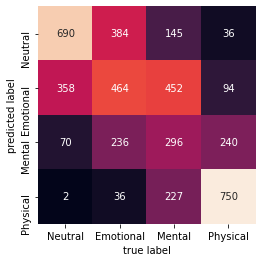

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.55      0.62      0.58      1120
   Emotional       0.34      0.41      0.37      1120
      Mental       0.35      0.26      0.30      1120
    Physical       0.74      0.67      0.70      1120

    accuracy                           0.49      4480
   macro avg       0.49      0.49      0.49      4480
weighted avg       0.49      0.49      0.49      4480

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs
Classification for set HANDk=80
CONFUSION MATRIX


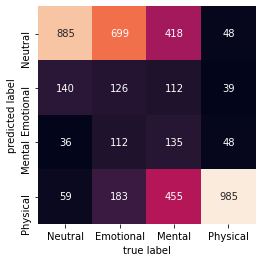

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.43      0.79      0.56      1120
   Emotional       0.30      0.11      0.16      1120
      Mental       0.41      0.12      0.19      1120
    Physical       0.59      0.88      0.70      1120

    accuracy                           0.48      4480
   macro avg       0.43      0.48      0.40      4480
weighted avg       0.43      0.48      0.40      4480

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 9.3 µs
CPU times: user 8min 9s, sys: 15min 45s, total: 23min 54s
Wall time: 7min 24s


In [95]:
%%time

reg_linear = LogisticRegression()

# k is the number of subjects available in the design database: 40 subjects
k = n_subject

print("CLASSIFICATION FOR: LSLC")
for f_set in Feature_Set:
    for k in N_max:
        print("Classification for set "+ f_set +"k="+str(k))

        X_selected = X[report[f_set][k]["Chosen Feats"]]

        y_lstsq = y
        np.linalg.lstsq(X_selected, y_lstsq)

        # cross validation
        y_pred = cross_val_predict(reg_linear, X_selected, y_lstsq, cv=cv)
        get_confusion_matrix(y_pred)
        get_classification_report(y_pred)
        %time

### Least Squares Quadratic Classifier (LSQC)

CLASSIFICATION FOR: LSQC
Classification for set ECGk=5
CONFUSION MATRIX


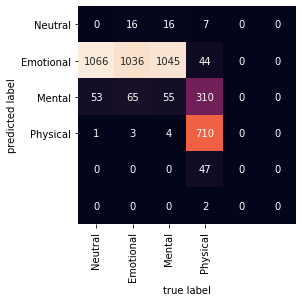

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.3 µs
Classification for set ECGk=10
CONFUSION MATRIX


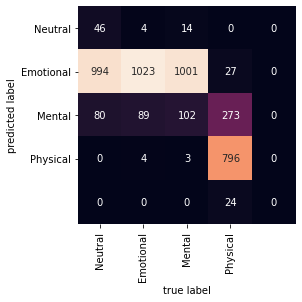

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs
Classification for set ECGk=20
CONFUSION MATRIX


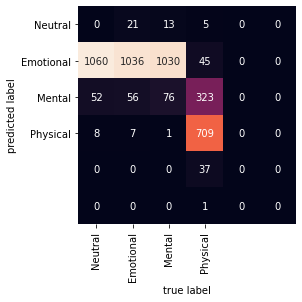

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.91 µs
Classification for set ECGk=40
CONFUSION MATRIX


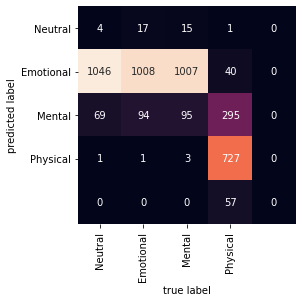

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.91 µs
Classification for set ECGk=80
CONFUSION MATRIX


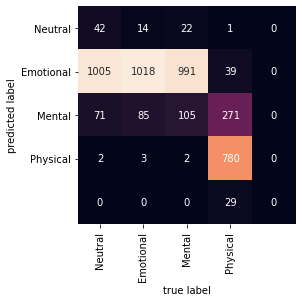

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs
Classification for set TEBk=5
CONFUSION MATRIX


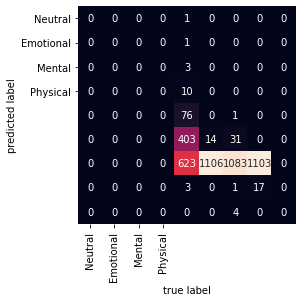

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.44 µs
Classification for set TEBk=10
CONFUSION MATRIX


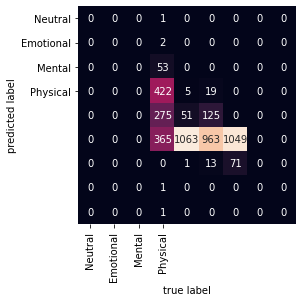

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs
Classification for set TEBk=20
CONFUSION MATRIX


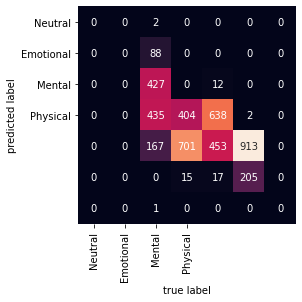

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs
Classification for set TEBk=40
CONFUSION MATRIX


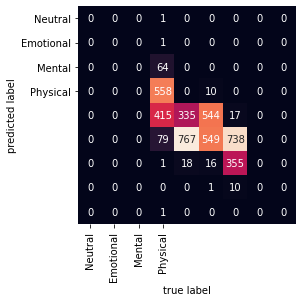

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs
Classification for set TEBk=80
CONFUSION MATRIX


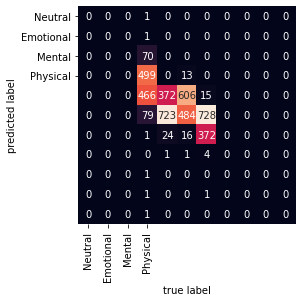

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs
Classification for set ARMk=5
CONFUSION MATRIX


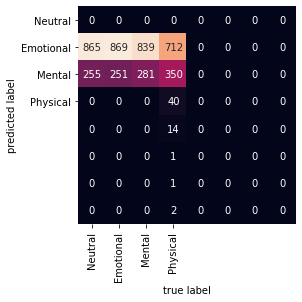

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs
Classification for set ARMk=10
CONFUSION MATRIX


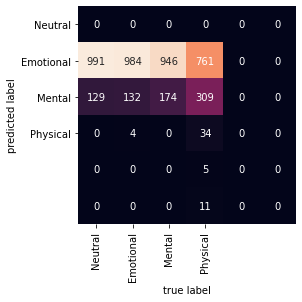

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
Classification for set ARMk=20
CONFUSION MATRIX


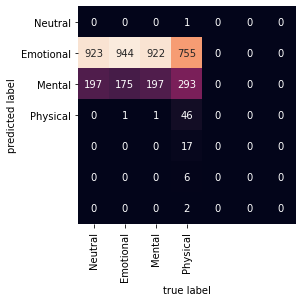

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.3 µs
Classification for set ARMk=40
CONFUSION MATRIX


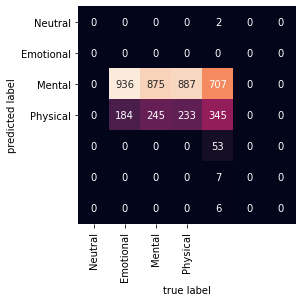

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs
Classification for set ARMk=80
CONFUSION MATRIX


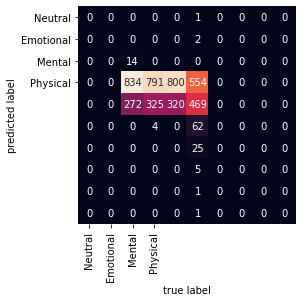

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
Classification for set HANDk=5
CONFUSION MATRIX


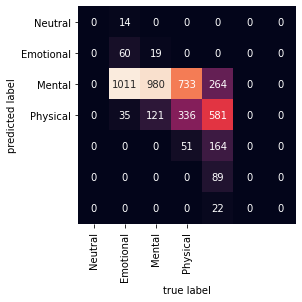

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs
Classification for set HANDk=10
CONFUSION MATRIX


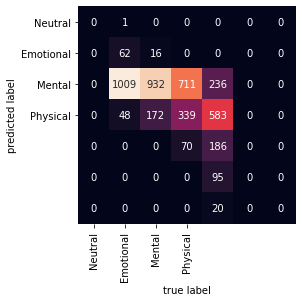

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs
Classification for set HANDk=20
CONFUSION MATRIX


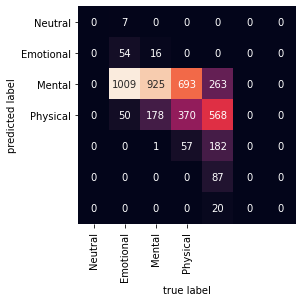

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.48 µs
Classification for set HANDk=40
CONFUSION MATRIX


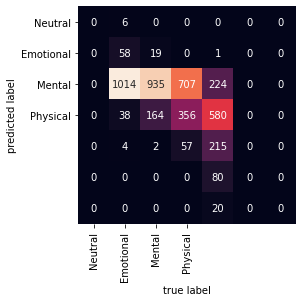

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.77 µs
Classification for set HANDk=80
CONFUSION MATRIX


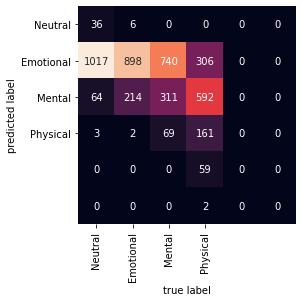

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs
CPU times: user 18.4 s, sys: 16.9 s, total: 35.3 s
Wall time: 14.5 s


In [93]:
%%time
poly = PolynomialFeatures(degree=2)

reg_quadratic = make_pipeline(PolynomialFeatures(2), StandardScaler(), LogisticRegression())

print("CLASSIFICATION FOR: LSQC")
for f_set in Feature_Set:
    for k in N_max:
        print("Classification for set "+ f_set +"k="+str(k))

        X_selected = X[report[f_set][k]["Chosen Feats"]]

        y_lstsq = y
        np.linalg.lstsq(X_selected, y_lstsq)

        # cross validation
        y_pred = cross_val_predict(reg_linear, X_selected, y_lstsq, cv=cv)
        get_confusion_matrix(y_pred)
        get_classification_report(y_pred)
        %time

### Support Vector Machines Linear (SVMs_lin)

CLASSIFICATION FOR:vsmc_linear
Classification for set ECGk=5
CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.43      0.37      0.40      1120
   Emotional       0.39      0.48      0.43      1120
      Mental       0.44      0.42      0.43      1120
    Physical       0.88      0.82      0.85      1120

    accuracy                           0.52      4480
   macro avg       0.53      0.52      0.53      4480
weighted avg       0.53      0.52      0.53      4480

Classification for set ECGk=10
CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.19      0.21      0.20      1120
   Emotional       0.26      0.32      0.29      1120
      Mental       0.32      0.39      0.35      1120
    Physical       0.57      0.29      0.39      1120

    accuracy                           0.30      4480
   macro avg       0.34      0.30      0.31      4480
weighted avg   

CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.24      0.32      0.27      1120
   Emotional       0.29      0.31      0.30      1120
      Mental       0.23      0.23      0.23      1120
    Physical       0.37      0.21      0.27      1120

    accuracy                           0.27      4480
   macro avg       0.28      0.27      0.27      4480
weighted avg       0.28      0.27      0.27      4480

Classification for set HANDk=40
CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.37      0.44      0.41      1120
   Emotional       0.27      0.39      0.32      1120
      Mental       0.29      0.27      0.28      1120
    Physical       0.58      0.28      0.37      1120

    accuracy                           0.34      4480
   macro avg       0.38      0.34      0.34      4480
weighted avg       0.38      0.34      0.34      4480

Classification for s

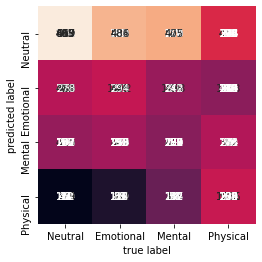

In [21]:
%%time
vsmc_linear = SVC(kernel='linear', random_state=0, probability=True,max_iter=1000)
apply_classifier_to_dataset(vsmc_linear,"vsmc_linear")
%time

### Support Vector Machines (SVMs_rbf)

CLASSIFICATION FOR:vsmc_rbf
Classification for set ECGk=5
CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.46      0.29      0.36      1120
   Emotional       0.40      0.49      0.44      1120
      Mental       0.51      0.54      0.53      1120
    Physical       0.86      0.93      0.89      1120

    accuracy                           0.56      4480
   macro avg       0.56      0.56      0.55      4480
weighted avg       0.56      0.56      0.55      4480

Classification for set ECGk=10
CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.36      0.37      0.37      1120
   Emotional       0.41      0.14      0.21      1120
      Mental       0.36      0.57      0.44      1120
    Physical       0.86      0.91      0.89      1120

    accuracy                           0.50      4480
   macro avg       0.50      0.50      0.47      4480
weighted avg      

CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.43      0.79      0.56      1120
   Emotional       0.38      0.22      0.28      1120
      Mental       0.38      0.18      0.25      1120
    Physical       0.65      0.71      0.68      1120

    accuracy                           0.48      4480
   macro avg       0.46      0.48      0.44      4480
weighted avg       0.46      0.48      0.44      4480

Classification for set HANDk=40
CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.41      0.72      0.52      1120
   Emotional       0.37      0.28      0.32      1120
      Mental       0.36      0.16      0.22      1120
    Physical       0.69      0.70      0.69      1120

    accuracy                           0.47      4480
   macro avg       0.46      0.47      0.44      4480
weighted avg       0.46      0.47      0.44      4480

Classification for s

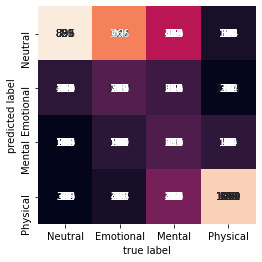

In [22]:
%%time
vsmc_rbf = SVC(kernel='rbf', random_state=0, probability=True,max_iter=1000) #Support Vector Machine Gaussian Kernel
apply_classifier_to_dataset(vsmc_rbf,"vsmc_rbf")
%time

### Multi-layer Perceptrons (MLPs)

CLASSIFICATION FOR:mlpc
Classification for set ECGk=5
CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.41      0.34      0.37      1120
   Emotional       0.38      0.36      0.37      1120
      Mental       0.48      0.55      0.52      1120
    Physical       0.87      0.93      0.89      1120

    accuracy                           0.54      4480
   macro avg       0.53      0.54      0.54      4480
weighted avg       0.53      0.54      0.54      4480

Classification for set ECGk=10
CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.35      0.28      0.31      1120
   Emotional       0.38      0.40      0.39      1120
      Mental       0.43      0.50      0.46      1120
    Physical       0.92      0.90      0.91      1120

    accuracy                           0.52      4480
   macro avg       0.52      0.52      0.52      4480
weighted avg       0.5

CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.43      0.47      0.45      1120
   Emotional       0.32      0.31      0.32      1120
      Mental       0.33      0.28      0.31      1120
    Physical       0.67      0.72      0.69      1120

    accuracy                           0.45      4480
   macro avg       0.44      0.45      0.44      4480
weighted avg       0.44      0.45      0.44      4480

Classification for set HANDk=40
CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.47      0.49      0.48      1120
   Emotional       0.33      0.35      0.34      1120
      Mental       0.28      0.26      0.27      1120
    Physical       0.64      0.61      0.62      1120

    accuracy                           0.43      4480
   macro avg       0.43      0.43      0.43      4480
weighted avg       0.43      0.43      0.43      4480

Classification for s

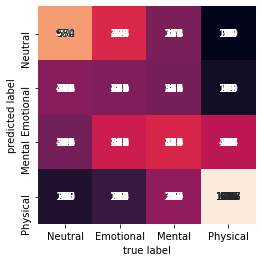

In [23]:
%%time
mlpc=MLPClassifier(random_state=1, max_iter=1000) #multilayer perceptron classifier
apply_classifier_to_dataset(mlpc,"mlpc")
%time

### k-Nearest Neighbor (kNN)

#### Computation of the best key value

In [24]:
# Find k best value from knn
#error = []

# Calculating error for K values between 1 and 40
#for i in range(1, 40):
#    knn = KNeighborsClassifier(n_neighbors=i)
#    knn.fit(X, y)
#    y_pred = cross_val_predict(knn, X, y, cv=n_subject)
#    pred_i = knn.predict(X_test)
#    error.append(np.mean(pred_i != y_test))
    
#plt.figure(figsize=(12, 6))
#plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
#plt.title('Error Rate K Value')
#plt.xlabel('K Value')
#plt.ylabel('Mean Error')

NameError: name 'X_train' is not defined

In [ ]:
%%time
knnc=KNeighborsClassifier(n_neighbors=25) # k value suggested in the pdf
apply_classifier_to_dataset(knnc,"knnc")
%time

### Centroid Displacement-Based k-Nearest Neighbor (CDNN)

### Random Forests (RF)

In [ ]:
%%time
rfc=RandomForestClassifier(n_estimators=100)
apply_classifier_to_dataset(rfc,"rfc")
%time

In [ ]:
accuracies=[accuracy_svm_linear,accuracy_svm_rbf,accuracy_mlp,accuracy_knn,accuracy_rf]
labels=["VSM_linear","VSM_rbf","mlp","knn","rf"]

In [ ]:
print_accuracy_table(accuracies,classificator_label);